<a href="https://colab.research.google.com/github/renneruan/bert-text-classifier/blob/main/bert_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo BERT como classificador de texto

Vamos utilizar a biblioteca HuggingFace que fornece uma API de abstração para manipularmos modelos de linguagem, principalmente direcionados para tarefas de NLP. É necessário a autenticação com uma chave de API para a execução do código.

Também será necessário a utilização de uma chave de registro ao Wandb, necessário para armazenar os logs dos experimentos para o treinamento realizado.

In [2]:
# !pip install transformers datasets umap-learn

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import gc

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

In [2]:
from huggingface_hub import notebook_login
notebook_login()

### Dados de saúde (Dmoz Health)

#### Divisão de dados

Por se tratar de dados não inerentes aos datasets originais do HuggingFace, devemos processar a leitura dos dados desejados e dividí-los em splits de treino, teste e validação.

In [3]:
health_dataset = load_dataset(
    "csv",
    data_files="Dmoz-Health.csv",
    sep=","
)
health_dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'class'],
        num_rows: 6500
    })
})

Temos a presença de 13 classes nos textos

In [4]:
print(set(health_dataset["train"]["class"]))

{'Medicine', 'Nursing', 'Pharmacy', 'Alternative', 'Public', 'Animal', 'Nutrition', 'Addictions', 'Professions', 'Senior', 'Reproductive', 'Mental', 'Conditions'}


Para evitar confusão com a palavra `class` reservada pelo Python, iremos alterar o valor da coluna *target* para `label`.

In [5]:
health_dataset = health_dataset.rename_column("class", "label")
health_dataset = health_dataset.class_encode_column("label")

A API do HuggingFace não fornece a possibilidade de uma divisão de treino, teste e validação, para isso precisamos realizar o processo de divisão 2 vezes, de acordo com as porcentagens desejadas.

Vamos utilizar: Treino 70%, Validação 10% e Teste 20%.

In [6]:
test_splitted_health_dataset = health_dataset["train"].train_test_split(
    test_size=0.3,
    stratify_by_column="label" # Preserva a distribuição dos dados de label
) # Irá resultar em um dataset contendo Treino e Teste

In [7]:
# A partir do conjunto de teste, vamos dividí-lo novamente em Teste e Validação
# A partir do original o dataset de teste possui 30% dos dados
# Para termos 20% e 10% vamos assumí-lo como o novo 100% e dividí-lo em 3 (66%/33%)
validation_splitted_health_dataset = test_splitted_health_dataset["test"].train_test_split(
    test_size=0.66,
    stratify_by_column="label"
)

Precisamos utilizar agora as divisões correspondentes dos conjuntos de  `train` e `test` de acordo com as porcentagens das divisões. Esta parte requer um pouco de atenção, pois na última instrução temos que os dados de teste foram divididor novamente em um conjunto `train` e `test`, contendo 20% e 10% dos dados originais respectivamente, mesmo com a nomeclatura `train`, iremos direcionar esses dados para o conjunto de teste, e o `test` para o de validação.

In [8]:
splitted_health_dataset = DatasetDict({
    'train': test_splitted_health_dataset['train'], #
    'validation': validation_splitted_health_dataset['train'],
    'test': validation_splitted_health_dataset['test']
})

Podemos ver a correta proporção de divisão

In [9]:
splitted_health_dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 4550
    })
    validation: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 663
    })
    test: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 1287
    })
})

Vamos transformar em DataFrame pandas para verificar o tamanho de palavras que os textos nos fornecem. Tal verificação é necessário para termos um panorama de quantos tokens serão gerados para o texto correspondente, uma vez que o modelo BERT possui uma entrada de 512 tokens máximos.

In [10]:
splitted_health_dataset.set_format(type="pandas")
df = splitted_health_dataset["train"][:]
df.head()

,file_name,text,label
0,1586040.txt,East Hill Dog &amp; Cat Hospital Veterinary cl...,2
1,1623433.txt,McConnell Institute Information on the McConne...,9
2,Health_1628934.txt,The Weatherly Inn A retirement community offer...,12
3,and_Diseases_1591232.txt,CaringBridge: Callie Provides journal and trea...,3
4,1609690.txt,Indian Journal of Pediatrics A monthly publica...,4


Os datasets criados pelo HuggingFace transformão as colunas de target diretamente em valores inteiros, para termos a correspondência com a string original realizamos o mapeamento com a função `health_label_int2str`.

In [11]:
def health_label_int2str(row):
    return splitted_health_dataset["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(health_label_int2str)
df.head()

,file_name,text,label,label_name
0,1586040.txt,East Hill Dog &amp; Cat Hospital Veterinary cl...,2,Animal
1,1623433.txt,McConnell Institute Information on the McConne...,9,Professions
2,Health_1628934.txt,The Weatherly Inn A retirement community offer...,12,Senior
3,and_Diseases_1591232.txt,CaringBridge: Callie Provides journal and trea...,3,Conditions
4,1609690.txt,Indian Journal of Pediatrics A monthly publica...,4,Medicine


Checando a distribuição do tamanho dos textos em palavras, temos o seguinte gráfico.

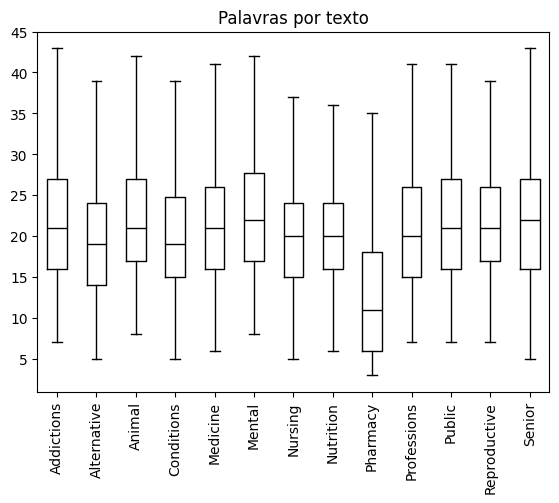

In [12]:
df["Palavras por texto"] = df["text"].str.split().apply(len)

df.boxplot(
    "Palavras por texto",
    by="label_name",
    grid=False,
    showfliers=False,
    color="black"
)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

Verificamos a quantia de palavras menor que 50. Utilizando um tokenizador por palavras ou subwords, não termos problema de informação truncada a ser repassada como entrada para o BERT.

#### Tokenização

Vamos utilizar o modelo `distilbert-base-uncased` devido a seu menor "volume", porém mantendo bons resultados. Sendo para a tarefa que desejamos um bom candidato de custo benefício.

In [13]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # Resgata tokenizador distilbert

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Vamos verificar o resultado de um registro dos dados após tokenização.

In [14]:
encoded_sample = tokenizer(df.iloc[0].text)
print(encoded_sample)
print(len(encoded_sample["input_ids"]))


{'input_ids': [101, 2264, 2940, 3899, 1004, 23713, 1025, 4937, 2902, 15651, 9349, 2284, 1999, 2417, 8448, 1012, 2950, 4751, 1997, 1996, 2578, 1998, 4128, 1010, 1996, 29525, 2015, 1010, 3095, 1010, 3295, 1998, 2847, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
35


Para otimizarmos o processo de tokenização vamos utilizar o processamento em batch dos textos. Para isso precisamos de uma função a ser aplicada aos dados possuindo o tokenizador.

In [15]:
def tokenize(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["text"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True)

  # Preserva a coluna label de saída no map
  encodings["label"] = batch["label"]

  return encodings

In [16]:
health_text_encoded = splitted_health_dataset.map(
    tokenize,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map:   0%|          | 0/4550 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

Vamos verificar a saída da tokenização.

In [17]:
health_text_encoded["train"].column_names

['label', 'input_ids', 'attention_mask']

In [18]:
health_text_encoded["train"][:5]

,label,input_ids,attention_mask
0,2,"[101, 2264, 2940, 3899, 1004, 23713, 1025, 493...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,9,"[101, 28514, 2820, 2592, 2006, 1996, 23680, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,12,"[101, 1996, 4633, 2135, 7601, 1037, 5075, 2451...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,"[101, 11922, 6374, 1024, 20072, 3640, 3485, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,"[101, 2796, 3485, 1997, 23614, 2015, 1037, 705...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


#### Classificação por extração de features

Ao usarmos um transformer como extrator de características, temos o congelamento dos pesos do modelo base durante o treinamento, utilizamos apenas o resultado da camada oculta final como features para um classificador.

In [19]:
# Vamos utilizar GPU se tivermos
# Utilizando a API do HuggingFace repassamos o modelo distilbert para a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Vamos usar a mesma lógica de batch para extrair os resultados da camada oculta.


In [20]:
def extract_hidden_states(batch):

    # Repassa entradas do modelo para a GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad(): # Congela o modelo BERT, ou seja não calcula gradiente
        last_hidden_state = model(**inputs).last_hidden_state

    # Retornamos os valore da camada oculta para a CPU como um array Numpy
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

   A função retorna o vetor do token [CLS], que é usado para representar toda a sequência, sendo uma boa forma de classificarmos o batch de texto. Ao usarmos [:, 0] selecionamos o estado oculto do primeiro token que captura o significado geral da entrada.

In [21]:
health_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
health_hidden_features = health_text_encoded.map(
    extract_hidden_states,
    batched=True
)


Map:   0%|          | 0/4550 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

In [22]:
health_hidden_features["train"].column_names

['label', 'input_ids', 'attention_mask', 'hidden_state']

Resgatando nossas divisões dos Datasets criados.

In [23]:
X_health_train = np.array(health_hidden_features["train"]["hidden_state"])
y_health_train = np.array(health_hidden_features["train"]["label"])

X_health_validation = np.array(health_hidden_features["validation"]["hidden_state"])
y_health_validation = np.array(health_hidden_features["validation"]["label"])

X_health_test = np.array(health_hidden_features["test"]["hidden_state"])
y_health_test = np.array(health_hidden_features["test"]["label"])

X_health_train.shape, X_health_validation.shape, X_health_test.shape

((4550, 768), (663, 768), (1287, 768))

Vamos visualizar utilizando o UMAP (Algoritmo de redução de dimensionalidade) para verificarmos como os valores de estado oculto de nossas categorias estão se comportando em um espaço 2D.

In [24]:
X_health_scaled = MinMaxScaler().fit_transform(X_health_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_health_scaled)


df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_health_train
df_embedding.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,0.493784,2.867992,2
1,1.638742,6.379546,9
2,-0.864990,4.038207,12
3,2.156358,6.538564,3
4,0.139819,9.200507,4


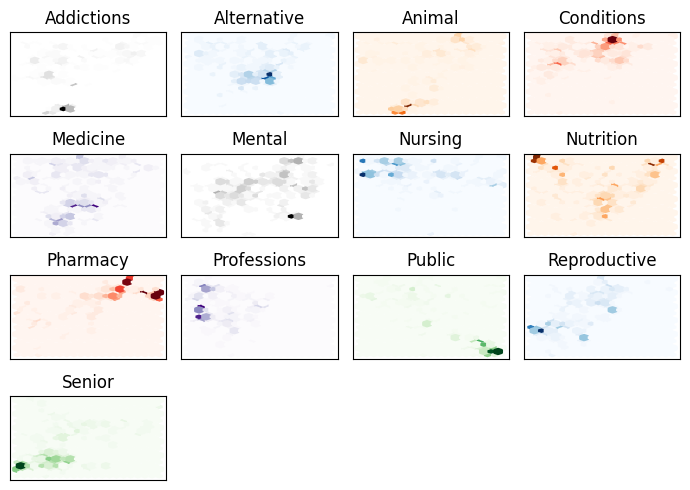

In [25]:
fig, axes = plt.subplots(4, 4, figsize=(7,5))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples"]
cmaps = cmaps + ["Greys", "Blues", "Oranges", "Reds", "Purples"]
cmaps = cmaps + ["Greens", "Blues", "Greens"]

health_labels = splitted_health_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(health_labels, cmaps)):
    df_embedding_sub = df_embedding.query(f"label == {i}")

    axes[i].hexbin(
        df_embedding_sub["X"],
        df_embedding_sub["Y"],
        cmap=cmap,
        gridsize=20,
        linewidths=(0,2)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

for ax in axes[13:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


Vamos aplicar os resultados da camada oculta a um modelo base de regressão logística.

In [26]:
lr_health_clf = LogisticRegression(max_iter=3000)
lr_health_clf.fit(X_health_train, y_health_train)
lr_health_clf.score(X_health_test, y_health_test)

0.804972804972805

In [27]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

    plt.title("Matriz de confusão normalizada")
    plt.xticks(rotation=90)
    plt.show()


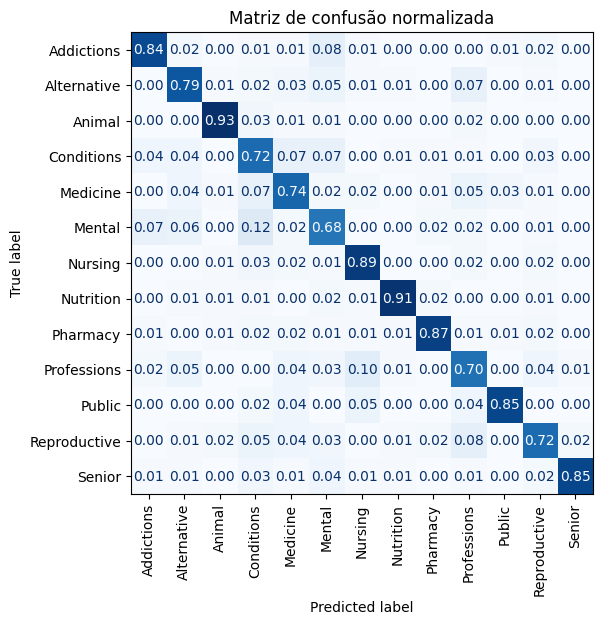

In [28]:
y_health_preds = lr_health_clf.predict(X_health_test)
plot_confusion_matrix(y_health_preds, y_health_test, health_labels)

#### Classificação por Fine-tuning

Como fine-tuning, vamos alterar os pesos do modelo BERT de acordo com nossos dados de treino e validação.

In [29]:
num_labels = len(health_labels)
health_model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Estas vão ser as métricas que vão ser utilizadas para o treinamento, necessárias para o processo de gradiente e aprendizado.

In [30]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

Construindo o objeto de configurações para o treinamento do modelo.

In [31]:
batch_size = 32
num_train_epochs=5
learning_rate=2e-5

health_logging_steps = len(health_text_encoded["train"]) // batch_size

health_model_name = f"{model_ckpt}-finetuned-health-text-classification"
health_training_args = TrainingArguments(output_dir=health_model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=health_logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Aplicando a interface de treinamento.

In [32]:
trainer = Trainer(model=health_model,
                  args=health_training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=health_text_encoded["train"],
                  eval_dataset=health_text_encoded["validation"], # Utilizar parcela de validação
                  tokenizer=tokenizer) # Utilizar o distilBERT inicialmente carregado

trainer.train()

<ipython-input-32-03fbdb889336>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=health_model,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: renneruan (renneruan-university-of-brasilia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.795200,1.009334,0.814480,0.814494
2,0.714900,0.655498,0.849170,0.849322
3,0.412400,0.583520,0.859729,0.860142
4,0.288800,0.568267,0.847662,0.848675
5,0.233500,0.563208,0.855204,0.855688


TrainOutput(global_step=715, training_loss=0.6856117500291837, metrics={'train_runtime': 229.8395, 'train_samples_per_second': 98.982, 'train_steps_per_second': 3.111, 'total_flos': 565167094128000.0, 'train_loss': 0.6856117500291837, 'epoch': 5.0})

Agora nosso modelo pode prever como uma camada final a partir dos dados de teste.

In [33]:
health_predictions_output = trainer.predict(health_text_encoded["test"])

In [34]:
health_predictions_output.metrics

{'test_loss': 0.4284702241420746,
 'test_accuracy': 0.8912198912198912,
 'test_f1': 0.8911760048913215,
 'test_runtime': 3.5239,
 'test_samples_per_second': 365.224,
 'test_steps_per_second': 11.635}

In [35]:
health_predictions_output.predictions

array([[-7.7477443e-01, -9.8227745e-01, -5.2078086e-01, ...,
        -8.5319412e-01, -7.9827309e-01, -8.2901329e-01],
       [-1.1217780e+00, -2.3291588e-01,  1.6704983e-01, ...,
        -1.0630802e+00, -9.9392551e-01, -9.8992521e-01],
       [-1.2645547e+00, -9.9824184e-01, -7.9281455e-01, ...,
         5.5835336e-01, -1.0181364e+00, -9.9835694e-01],
       ...,
       [-4.4618267e-01, -1.1290984e+00, -8.4937984e-01, ...,
        -1.0973500e+00,  4.7118015e+00, -8.5947490e-01],
       [-1.6347719e+00, -1.2886398e+00,  5.8302651e-03, ...,
        -5.5346680e-01, -3.3270469e-01, -8.4302527e-01],
       [-1.0777088e+00, -3.0950120e-01,  2.6113488e-04, ...,
        -9.5234555e-01, -9.2971230e-01, -1.0270360e+00]], dtype=float32)

Utilizamos o argmax para transformar o resultado de predição para uma correspondência de classes igual a um classificador comum.

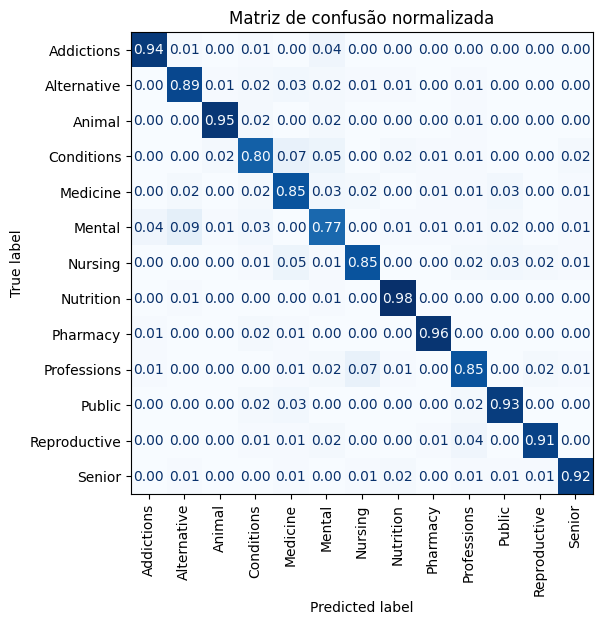

In [36]:
y_health_predictions = np.argmax(health_predictions_output.predictions, axis=1)
plot_confusion_matrix(y_health_predictions, y_health_test, health_labels)

Percebemos uma melhora de realizar o treinamento do modelo como estratégia de Fine-tuning ao invés de apenas usar as camadas ocultas, porém a primeira estratégia ainda tem um desempenho considerável! Utilizando apenas um modelo simples como regressão logística, se aplicarmos a uma estratégia mais robusta poderiamos ter melhoras significativas. O mesmo se aplica a aumentar o número de épocas de treinamento pela estratégia de Fine-tuning.

Vamos limpar os dados da camada oculta que estão ocupando a GPU. Isso possibilita que possamos utilizá-la para os dados industriais.

In [37]:
# Para limparmos a memória da GPU

del health_text_encoded
del health_hidden_features
del trainer
del health_predictions_output

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

# del trainer

13514

### Dados de Setor Industrial

#### Divisão dos Dados

Vamos repetir os mesmos procedimentos para os dados de setor industrial.

In [38]:
industry_dataset = load_dataset(
    "csv",
    data_files="Industry Sector.csv",
    sep=","
)
industry_dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'class'],
        num_rows: 8817
    })
})

In [39]:
print(set(industry_dataset["train"]["class"]))

{'financial', 'utilities', 'basic', 'technology', 'capital', 'consumer', 'energy', 'transportation', 'services', 'healthcare', 'conglomerates'}


Possuímos 11 classes para o dataset.

In [40]:
industry_dataset = industry_dataset.rename_column("class", "label")
industry_dataset = industry_dataset.class_encode_column("label")

Dividir os splits de teste e validação.

In [41]:
test_splitted_industry_dataset = industry_dataset["train"].train_test_split(
    test_size=0.3,
    stratify_by_column="label"
)
validation_splitted_industry_dataset = test_splitted_industry_dataset["test"].train_test_split(
    test_size=0.66,
    stratify_by_column="label"
)

In [42]:
splitted_industry_dataset = DatasetDict({
    'train': test_splitted_industry_dataset['train'], #
    'validation': validation_splitted_industry_dataset['train'],
    'test': validation_splitted_industry_dataset['test']
})

splitted_industry_dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 6171
    })
    validation: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 1747
    })
})

Vamos visualizar rapidamente como os dados do Dataset se apresentam.

In [43]:
def industry_label_int2str(row):
    return splitted_industry_dataset["train"].features["label"].int2str(row)

splitted_industry_dataset.set_format(type="pandas")
df_2 = splitted_industry_dataset["train"][:]
df_2["label_name"] = df_2["label"].apply(industry_label_int2str)
df_2.head()

,file_name,text,label,label_name
0,http:^^www.youthservices.com^ysiinvst.htm,Allow-ranges: bytes Investor Information...,7,services
1,non-cyclical_http:^^www.brookegroup.com^agsett...,Brooke Group Ltd. - Attorneys Gene...,3,consumer
2,http:^^www.thornburg.com^portmanagers^portmana...,The Thornburg Family of Funds: Portfoli...,7,services
3,http:^^www.worldair.com^whatsnew.htm,World Airways - Press Releases ...,9,transportation
4,goods_http:^^www.libertyhomesinc.com^penn.htm,Liberty Pennsylvania Plants Penn...,1,capital


Vamos verificar a distribuição de palavras nos textos do setor industrial.

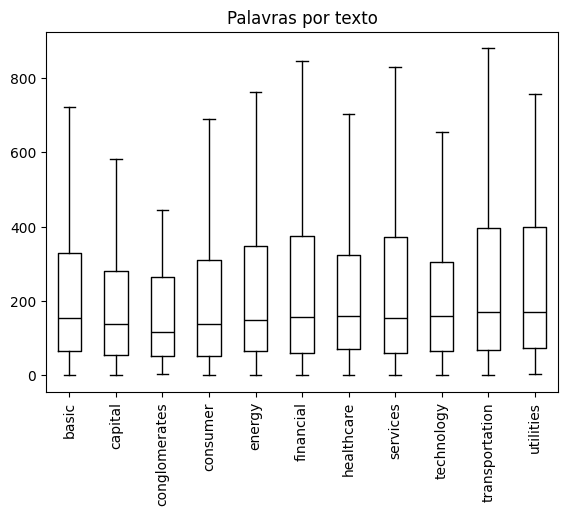

In [44]:
df_2["Palavras por texto"] = df_2["text"].str.split().apply(len)

df_2.boxplot(
    "Palavras por texto",
    by="label_name",
    grid=False,
    showfliers=False,
    color="black"
)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

Vemos que assumindo uma palavra por token, teríamos um excedente dos 512 tokens de entraga suportados pelo BERT, para o escopo deste trabalho vamos utilizar a opção básica de truncamento, porém pode ser uma melhoria a ser investigada, buscar formas de utilizar todo o texto.

#### Tokenização

In [45]:
# Como já construímos a função de tokenização em batch
industry_text_encoded = splitted_industry_dataset.map(
    tokenize,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

In [46]:
industry_text_encoded["train"].column_names

['label', 'input_ids', 'attention_mask']

In [47]:
industry_text_encoded["train"][:5]

,label,input_ids,attention_mask
0,7,"[101, 3499, 1011, 8483, 1024, 27507, 14316, 25...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,3,"[101, 11535, 2177, 5183, 1012, 1011, 16214, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,7,"[101, 1996, 16337, 4645, 2155, 1997, 5029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,9,"[101, 2088, 13095, 1011, 2811, 7085, 2811, 708...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,1,"[101, 7044, 3552, 4264, 3552, 7044, 5014, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


#### Classificação por extração de features

Como também já configuramos o modelo e as funções necessárias, vamos apenas aplicá-las aos dados novos.

In [48]:
industry_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
)

In [53]:
industry_hidden_features = industry_text_encoded.map(
    extract_hidden_states,
    batched=True,
    batch_size=8 # Batch size pequeno para prevenir overflow da GPU
)


Map:   0%|          | 0/6171 [00:00<?, ? examples/s]

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

In [54]:
industry_hidden_features["train"].column_names

['label', 'input_ids', 'attention_mask', 'hidden_state']

In [55]:
X_industry_train = np.array(industry_hidden_features["train"]["hidden_state"])
y_industry_train = np.array(industry_hidden_features["train"]["label"])

X_industry_validation = np.array(industry_hidden_features["validation"]["hidden_state"])
y_industry_validation = np.array(industry_hidden_features["validation"]["label"])

X_industry_test = np.array(industry_hidden_features["test"]["hidden_state"])
y_industry_test = np.array(industry_hidden_features["test"]["label"])

X_industry_train.shape, X_industry_validation.shape, X_industry_test.shape

((6171, 768), (899, 768), (1747, 768))

Visualizando os labels com o UMAP também temos:

In [56]:
X_industry_scaled = MinMaxScaler().fit_transform(X_industry_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_industry_scaled)


df_2_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_2_embedding["label"] = y_industry_train
df_2_embedding.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,8.777655,0.227262,7
1,11.081670,-1.011911,3
2,9.124353,0.328563,7
3,9.698363,-1.174350,9
4,11.480471,0.925673,1


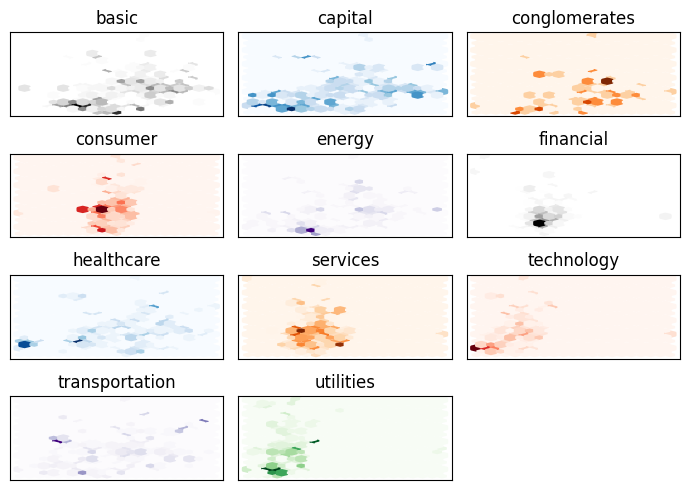

In [59]:
fig, axes = plt.subplots(4, 3, figsize=(7,5))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples"]
cmaps = cmaps + ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]

industry_labels = splitted_industry_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(industry_labels, cmaps)):
    df_2_embedding_sub = df_2_embedding.query(f"label == {i}")

    axes[i].hexbin(
        df_2_embedding_sub["X"],
        df_2_embedding_sub["Y"],
        cmap=cmap,
        gridsize=20,
        linewidths=(0,2)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

for ax in axes[11:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


Aplicando ao modelo de regressão logística.

In [61]:
lr_industry_clf = LogisticRegression(max_iter=3000)
lr_industry_clf.fit(X_industry_train, y_industry_train)
lr_industry_clf.score(X_industry_test, y_industry_test)

0.6353749284487693

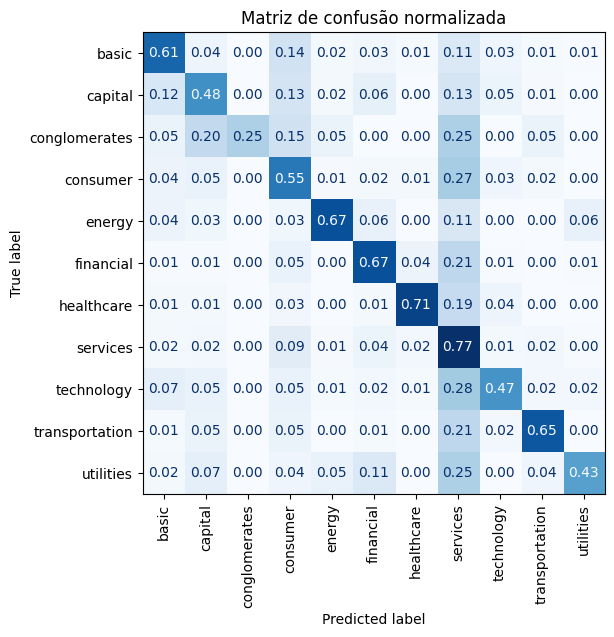

In [62]:
y_industry_preds = lr_industry_clf.predict(X_industry_test)
plot_confusion_matrix(y_industry_preds, y_industry_test, industry_labels)

Percebemos que para o dataset de textos industriais os valores utilizando regressão logística não foram tão satisfatórios, principalmente para a classe conglomerates, capital, techonologies e utilities.

#### Classificação por Fine Tuning

In [63]:
num_labels = len(industry_labels)
industry_model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))


In [64]:
batch_size = 64
num_train_epochs=5
learning_rate=2e-5

industry_logging_steps = len(industry_text_encoded["train"]) // batch_size

industry_model_name = f"{model_ckpt}-finetuned-industry-text-classification"
industry_training_args = TrainingArguments(output_dir=industry_model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=health_logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [65]:
trainer = Trainer(model=industry_model,
                  args=industry_training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=industry_text_encoded["train"],
                  eval_dataset=industry_text_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

<ipython-input-65-8ec8c10c5655>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=industry_model,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.566501,0.516129,0.459999
2,1.811800,1.086018,0.699666,0.681763
3,1.049000,0.896745,0.739711,0.731574
4,1.049000,0.817277,0.770857,0.764095
5,0.714200,0.786748,0.779755,0.773709


TrainOutput(global_step=485, training_loss=1.1225087588595362, metrics={'train_runtime': 1515.5257, 'train_samples_per_second': 20.359, 'train_steps_per_second': 0.32, 'total_flos': 4087937603312640.0, 'train_loss': 1.1225087588595362, 'epoch': 5.0})

Conseguimos ver o aumento substancial do F1 score na medida que mais épocas são computadas.

Computando diretamente a matriz de confusão para os dados de industria temos:

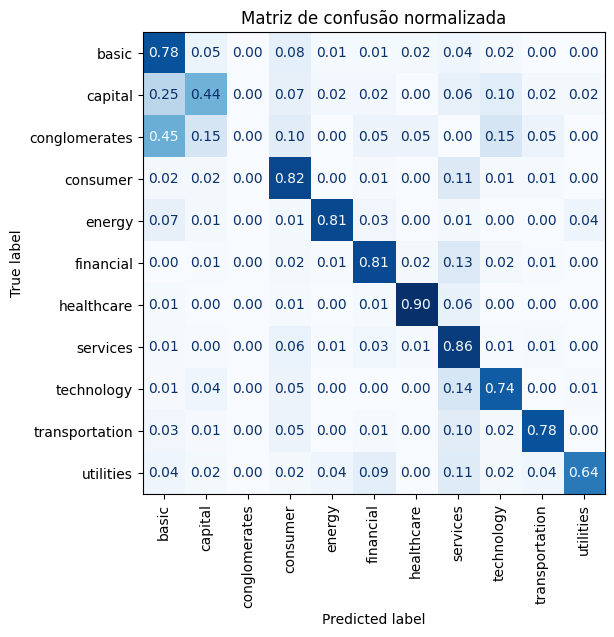

In [66]:
industry_predictions_output = trainer.predict(industry_text_encoded["test"])
y_industry_predictions = np.argmax(industry_predictions_output.predictions, axis=1)
plot_confusion_matrix(y_industry_predictions, y_industry_test, industry_labels)

Percebemos que com o Fine-tuning do modelo, sequer conseguimos classificar corretamente os dados da categoria conglomerates, porém para todas as outras tivemos uma melhora substancial das predições corretas.

Vamos tentar identificar o porque o dataset apresenta resultados ruins para a classe conglomerate.

In [70]:
df_2["label_name"].value_counts()

,count
label_name,
services,1816
consumer,1083
financial,671
basic,663
capital,444
transportation,354
technology,347
healthcare,278
energy,248


Temos que a classe conglomerates apresenta o menor número de ocorrências no dataset, provavelmente os textos apresentados não possuem características tão distintas que se acentuem das demais classes. Podemos verificar isso também observando os gráficos UMAP previamente amostrados, em que conglomerate, basic e capital possuem um espaço de embeddings 2D esparsados e semelhantes um ao outro.

---
## Conclusão

O tempo de processamento necessário pelo classificador utilizando apenas a camada oculta como features é bem menor que treinar o modelo como um todo, porém percebemos que ao lidar com datasets desbalanceados, não obtemos resultados consistentes para todas as classes. Necessitando que para estas sejam aplicadas estratégias de balanceamento ou a um classificador mais adequado.

Realizar o Fine-tuning de um modelo requer custos computacionais de GPU para que isto seja realizado em tempo hábil. Mesmo tendo escolhido o modelo distilBERT que é uma versão compactada do modelo padrão, foi necessário de aproximadamente 20 minutos para treinarmos as 5 épocas para apenas 8600 textos. Porém os resultados do classificador para classes balanceadas, foram superior a utilização da camada oculta como features, demonstrando a capacidade do grande modelo de linguagem. Poderiamos aumentar o número de épocas para uma maior quantidade, porém isto poderia ocasionar em um maior overfitting do modelo.

